In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sqlalchemy import create_engine
engine = create_engine('sqlite:///graphdata.db')
%matplotlib inline

In [34]:
stroke_data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

In [35]:
stroke_data.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

## Pre-existing Conditions

In [36]:
#combine hypertension and heart_disease into another column for pre existing conditions
pre_existing_conditions = (stroke_data['hypertension'] + stroke_data['heart_disease']).astype("bool")
stroke_data["pre_condition"] = pre_existing_conditions
stroke_data.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  pre_condition  
0       1           True  
1       1          False  
2       1           True  
3       1          False  
4       1           True

In [64]:
pre_existing = stroke_data.groupby(by = ["pre_condition"]).count()
pre_existing.to_sql("pre_existing",engine,if_exists = "replace")
pre_existing

id  gender   age  hypertension  heart_disease  ever_married  \
pre_condition                                                                  
False          4400    4400  4400          4400           4400          4400   
True            710     710   710           710            710           710   

               work_type  Residence_type  avg_glucose_level   bmi  \
pre_condition                                                       
False               4400            4400               4400  4273   
True                 710             710                710   636   

               smoking_status  stroke  body_type  is_user_diabetic  
pre_condition                                                       
False                    4400    4400       4400              4400  
True                      710     710        710               710

Text(0.5, 1.0, 'Pre-existing conditions in data')

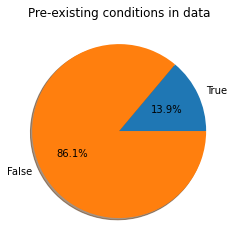

In [38]:
explode = [0,0]
pie_chart = plt.pie([pre_existing.loc[True].max(),pre_existing.loc[False].max()], explode = explode,labels = ["True","False"],shadow = True,autopct='%1.1f%%')
plt.title('Pre-existing conditions in data')

In [39]:
# create classes for bmi based on 

In [40]:
#get amount
genders = stroke_data.groupby(by = ["gender"]).count()
genders.to_sql("genders",engine,if_exists="replace")

Text(0.5, 1.0, 'Genders in Data')

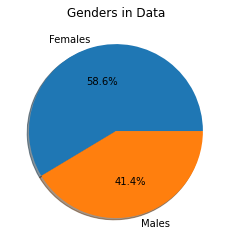

In [41]:
explode = [0,0]
pie_chart = plt.pie([genders.loc["Female"].max(),genders.loc["Male"].max()], explode = explode,labels = ["Females","Males"],shadow = True,autopct='%1.1f%%')
plt.title("Genders in Data")

Seems like there is a slight inbalance in the data with genders, hopefully this will not add unwanted bias

## Age exploration

Text(0, 0.5, 'Frequency')

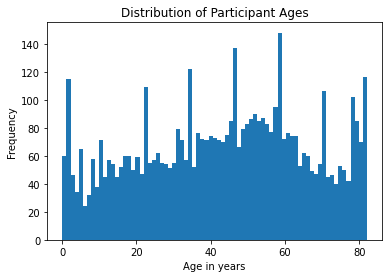

In [42]:
dist = plt.hist(stroke_data['age'],bins = 75)
plt.title("Distribution of Participant Ages")
plt.xlabel("Age in years")
plt.ylabel("Frequency")

In [43]:
stroke_data['age'].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

Seems we have a decent representation of ages here, standard deviation of 22.6 years

## NA Values


In [44]:
stroke_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
pre_condition          0
dtype: int64

## BMI and Blood Glucose Levels

In [45]:

num_cols = stroke_data.select_dtypes(exclude=  ["object"])
num_cols.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'pre_condition'],
      dtype='object')

In [46]:
#impute missing bmi values
imputer = SimpleImputer()

imputed_cols = imputer.fit_transform(num_cols)
imputed_cols = pd.DataFrame(data = imputed_cols,columns = num_cols.columns)
imputed_cols
# Write a function that creates different classes for bmi based on the CDC guidelines 
    
def bmi_to_bodytype(bmi):
    """
    desc : converts bmi to a category body type based on CDC guidelines https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html
    args:
        bmi (float) : the users bmi
    returns:
        bodytype (string) : The users bodytype
    """
    if bmi < 18.5:
        return "Underweight"
    
    elif 18.5 <= bmi < 24.9:
        return "Normal"
    
    elif 24.9 <= bmi < 29.9:
        return "Overweight"
    
    else:
        return "Obese"


In [47]:
def is_user_diabetic(avg_glucose_level):
    """
    desc: converts avg_glucose_level to category based on  ADA Guidelines https://www.diabetes.org/a1c/diagnosis
    args:
        avg_glucose_level (float) : glucose level in blood based on mg/dL
    returns:
        blood_cat (string) : blood sugar category
    """
    if avg_glucose_level >= 200:
        return True
    
    else:
        return False

In [48]:
#add the new categorical columns to our df
stroke_data["body_type"] =  imputed_cols["bmi"].apply(bmi_to_bodytype)
stroke_data["is_user_diabetic"] =  imputed_cols["avg_glucose_level"].apply(is_user_diabetic)
stroke_data.head(10)

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   
5        Private          Urban             186.21  29.0  formerly smoked   
6        Private          Rural              70.09  27.4     never smoked   
7        Private          Urban              94.39  22.8     never smoked   
8        Private          Rural              76.15   NaN          Unknown   
9        Private          Urban              58.57  24.2          Unknown   

   stroke  pre_condition   body_type  is_user_diabetic  
0       1           True       Obese              True  
1       1          False  Overweight              True  
2       1           True       Obese             False  
3       1          False       Obese             False  
4       1           True      Normal             False  
5       1          False  Overweight             False  
6       1           True  Overweight             False  
7       1          False      Normal             False  
8       1          False  Overweight             False  
9       1          False      Normal             False

In [49]:
#graph blood class
blood_classes = stroke_data.groupby(by = ["is_user_diabetic"]).count()
blood_classes.to_sql("diabetes",engine,if_exists="replace")

Text(0.5, 1.0, 'Diabetics in Data')

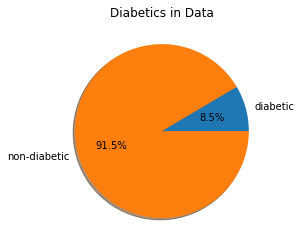

In [50]:
data = [blood_classes.loc[True].max(),blood_classes.loc[False].max()]
pie_chart = plt.pie(data ,labels =  ["diabetic","non-diabetic"],shadow = True,autopct='%1.1f%%')
plt.title("Diabetics in Data")

In [51]:
#drop na BMI's from the data 
bmi_data = stroke_data.dropna()
body_types = bmi_data.groupby(by = ["body_type"]).count()
body_types.to_sql("body_types",engine,if_exists = "replace")

Text(0.5, 1.0, 'Body Types in Data')

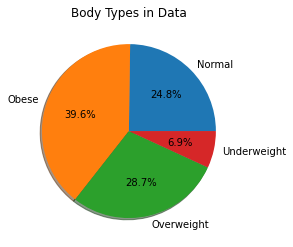

In [52]:
data = [body_types.loc["Normal"].max(),body_types.loc["Obese"].max(),body_types.loc["Overweight"].max(),body_types.loc["Underweight"].max()]
pie_chart = plt.pie(data ,labels =  ["Normal","Obese","Overweight","Underweight"],shadow = True,autopct='%1.1f%%')
plt.title("Body Types in Data")

A majority of the participants are either obese or overweight

## Setting up TSNE

In [53]:
#get numerical and categorical cols
cat_cols = stroke_data.select_dtypes(include = ["object"])
print(cat_cols.columns)
cat_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status', 'body_type'],
      dtype='object')


gender ever_married      work_type Residence_type   smoking_status  \
0       Male          Yes        Private          Urban  formerly smoked   
1     Female          Yes  Self-employed          Rural     never smoked   
2       Male          Yes        Private          Rural     never smoked   
3     Female          Yes        Private          Urban           smokes   
4     Female          Yes  Self-employed          Rural     never smoked   
...      ...          ...            ...            ...              ...   
5105  Female          Yes        Private          Urban     never smoked   
5106  Female          Yes  Self-employed          Urban     never smoked   
5107  Female          Yes  Self-employed          Rural     never smoked   
5108    Male          Yes        Private          Rural  formerly smoked   
5109  Female          Yes       Govt_job          Urban          Unknown   

       body_type  
0          Obese  
1     Overweight  
2          Obese  
3          Obese  
4         Normal  
...          ...  
5105  Overweight  
5106       Obese  
5107       Obese  
5108  Overweight  
5109  Overweight  

[5110 rows x 6 columns]

In [54]:

num_cols = stroke_data.select_dtypes(exclude=  ["object"])
num_cols.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'pre_condition', 'is_user_diabetic'],
      dtype='object')

In [55]:
encoded_cols = pd.get_dummies(cat_cols)
encoded_cols


gender_Female  gender_Male  gender_Other  ever_married_No  \
0                 0            1             0                0   
1                 1            0             0                0   
2                 0            1             0                0   
3                 1            0             0                0   
4                 1            0             0                0   
...             ...          ...           ...              ...   
5105              1            0             0                0   
5106              1            0             0                0   
5107              1            0             0                0   
5108              0            1             0                0   
5109              1            0             0                0   

      ever_married_Yes  work_type_Govt_job  work_type_Never_worked  \
0                    1                   0                       0   
1                    1                   0                       0   
2                    1                   0                       0   
3                    1                   0                       0   
4                    1                   0                       0   
...                ...                 ...                     ...   
5105                 1                   0                       0   
5106                 1                   0                       0   
5107                 1                   0                       0   
5108                 1                   0                       0   
5109                 1                   1                       0   

      work_type_Private  work_type_Self-employed  work_type_children  \
0                     1                        0                   0   
1                     0                        1                   0   
2                     1                        0                   0   
3                     1                        0                   0   
4                     0                        1                   0   
...                 ...                      ...                 ...   
5105                  1                        0                   0   
5106                  0                        1                   0   
5107                  0                        1                   0   
5108                  1                        0                   0   
5109                  0                        0                   0   

      Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
0                        0                     1                       0   
1                        1                     0                       0   
2                        1                     0                       0   
3                        0                     1                       0   
4                        1                     0                       0   
...                    ...                   ...                     ...   
5105                     0                     1                       0   
5106                     0                     1                       0   
5107                     1                     0                       0   
5108                     1                     0                       0   
5109                     0                     1                       1   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                                  1                            0   
1                                  0                            1   
2                                  0                            1   
3                                  0                            0   
4                                  0                            1   
...                              ...                          ...   
5105                               0                            1   
5106                          

In [56]:
#impute missing values again to take into account new columns
imputer = SimpleImputer()

imputed_cols = imputer.fit_transform(num_cols)
imputed_cols = pd.DataFrame(data = imputed_cols,columns = num_cols.columns)
imputed_cols

id   age  hypertension  heart_disease  avg_glucose_level  \
0      9046.0  67.0           0.0            1.0             228.69   
1     51676.0  61.0           0.0            0.0             202.21   
2     31112.0  80.0           0.0            1.0             105.92   
3     60182.0  49.0           0.0            0.0             171.23   
4      1665.0  79.0           1.0            0.0             174.12   
...       ...   ...           ...            ...                ...   
5105  18234.0  80.0           1.0            0.0              83.75   
5106  44873.0  81.0           0.0            0.0             125.20   
5107  19723.0  35.0           0.0            0.0              82.99   
5108  37544.0  51.0           0.0            0.0             166.29   
5109  44679.0  44.0           0.0            0.0              85.28   

            bmi  stroke  pre_condition  is_user_diabetic  
0     36.600000     1.0            1.0               1.0  
1     28.893237     1.0            0.0               1.0  
2     32.500000     1.0            1.0               0.0  
3     34.400000     1.0            0.0               0.0  
4     24.000000     1.0            1.0               0.0  
...         ...     ...            ...               ...  
5105  28.893237     0.0            1.0               0.0  
5106  40.000000     0.0            0.0               0.0  
5107  30.600000     0.0            0.0               0.0  
5108  25.600000     0.0            0.0               0.0  
5109  26.200000     0.0            0.0               0.0  

[5110 rows x 9 columns]

In [57]:
combined_df = pd.concat([imputed_cols,encoded_cols],axis = 1)
combined_df.index = combined_df["id"]
combined_df = combined_df.drop(columns = ["id"],axis = 1)
combined_df

age  hypertension  heart_disease  avg_glucose_level        bmi  \
id                                                                         
9046.0   67.0           0.0            1.0             228.69  36.600000   
51676.0  61.0           0.0            0.0             202.21  28.893237   
31112.0  80.0           0.0            1.0             105.92  32.500000   
60182.0  49.0           0.0            0.0             171.23  34.400000   
1665.0   79.0           1.0            0.0             174.12  24.000000   
...       ...           ...            ...                ...        ...   
18234.0  80.0           1.0            0.0              83.75  28.893237   
44873.0  81.0           0.0            0.0             125.20  40.000000   
19723.0  35.0           0.0            0.0              82.99  30.600000   
37544.0  51.0           0.0            0.0             166.29  25.600000   
44679.0  44.0           0.0            0.0              85.28  26.200000   

         stroke  pre_condition  is_user_diabetic  gender_Female  gender_Male  \
id                                                                             
9046.0      1.0            1.0               1.0              0            1   
51676.0     1.0            0.0               1.0              1            0   
31112.0     1.0            1.0               0.0              0            1   
60182.0     1.0            0.0               0.0              1            0   
1665.0      1.0            1.0               0.0              1            0   
...         ...            ...               ...            ...          ...   
18234.0     0.0            1.0               0.0              1            0   
44873.0     0.0            0.0               0.0              1            0   
19723.0     0.0            0.0               0.0              1            0   
37544.0     0.0            0.0               0.0              0            1   
44679.0     0.0            0.0               0.0              1            0   

         ...  Residence_type_Rural  Residence_type_Urban  \
id       ...                                               
9046.0   ...                     0                     1   
51676.0  ...                     1                     0   
31112.0  ...                     1                     0   
60182.0  ...                     0                     1   
1665.0   ...                     1                     0   
...      ...                   ...                   ...   
18234.0  ...                     0                     1   
44873.0  ...                     0                     1   
19723.0  ...                     1                     0   
37544.0  ...                     1                     0   
44679.0  ...                     0                     1   

         smoking_status_Unknown  smoking_status_formerly smoked  \
id                                                                
9046.0                        0                               1   
51676.0                       0                               0   
31112.0                       0                               0   
60182.0                       0                               0   
1665.0                        0                               0   
...                         ...                             ...   
18234.0                       0                               0   
44873.0                       0                               0   
19723.0                       0                               0   
37544.0                       0                               1   
44679.0                       1                               0   

         smoking_status_never smoked  smoking_status_smokes  body_type_Normal  \
id                                                                              
9046.0                             0                      0                 0   
51676.0                            1                      0                 0   
311

In [58]:
tsne = TSNE()
tsne_data = tsne.fit_transform(combined_df)

In [59]:
tsne_data

array([[-32.43816  ,  85.18574  ],
       [-14.511103 ,  77.32032  ],
       [ 49.061295 ,  27.537804 ],
       ...,
       [-41.51491  , -34.816326 ],
       [ -1.7632928,  61.07562  ],
       [-42.275257 , -13.102427 ]], dtype=float32)

In [60]:
#visualize results

Text(0.5, 1.0, 'TSNE Graph by Age')

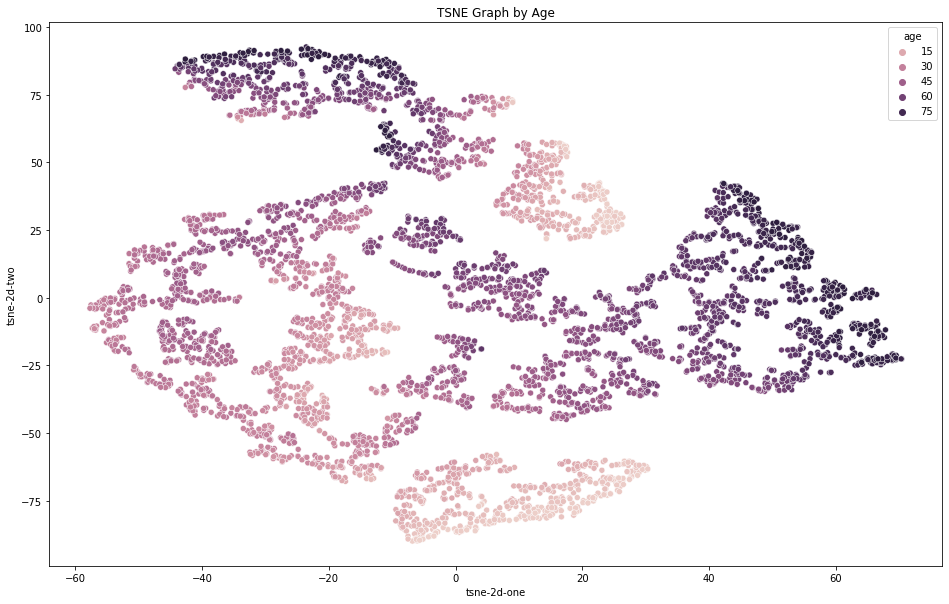

In [61]:
combined_df['tsne-2d-one'] = tsne_data[:,0]
combined_df['tsne-2d-two'] = tsne_data[:,1]
plt.figure(figsize=(16,10))
graph = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="age",
    data=combined_df,
    
  
)
graph.set_title("TSNE Graph by Age")

Seems like the data can be grouped into clusters by age, people with similiar ages tend to have similiar values all around.

Text(0.5, 1.0, 'TSNE Graph by Stroke')

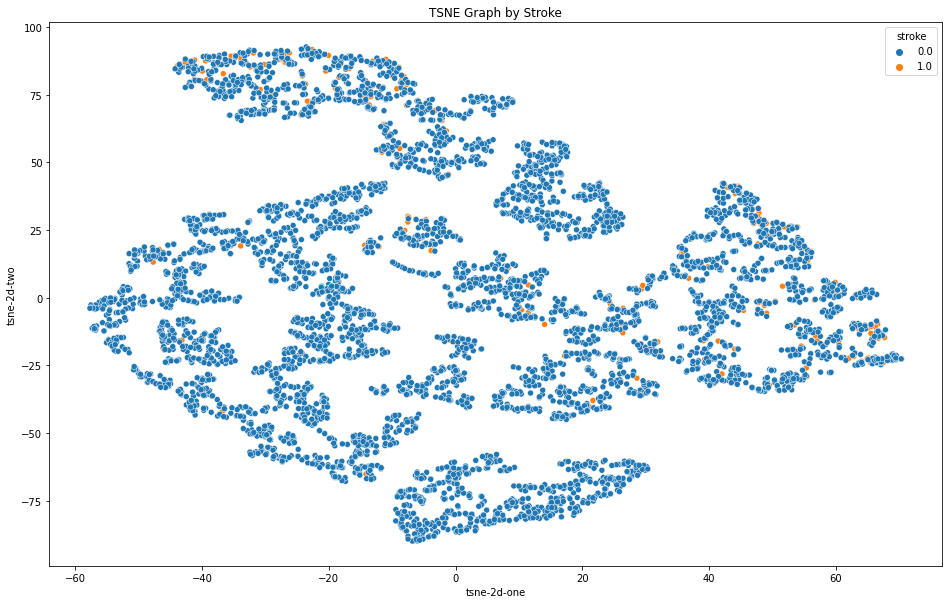

In [62]:

plt.figure(figsize=(16,10))
graph = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="stroke",
    data=combined_df,
    
  
)
graph.set_title("TSNE Graph by Stroke")

Seems like strokes are all across the board, maybe it will be hard to nail down a specific group of people at risk

Text(0.5, 1.0, 'TSNE Graph by BMI')

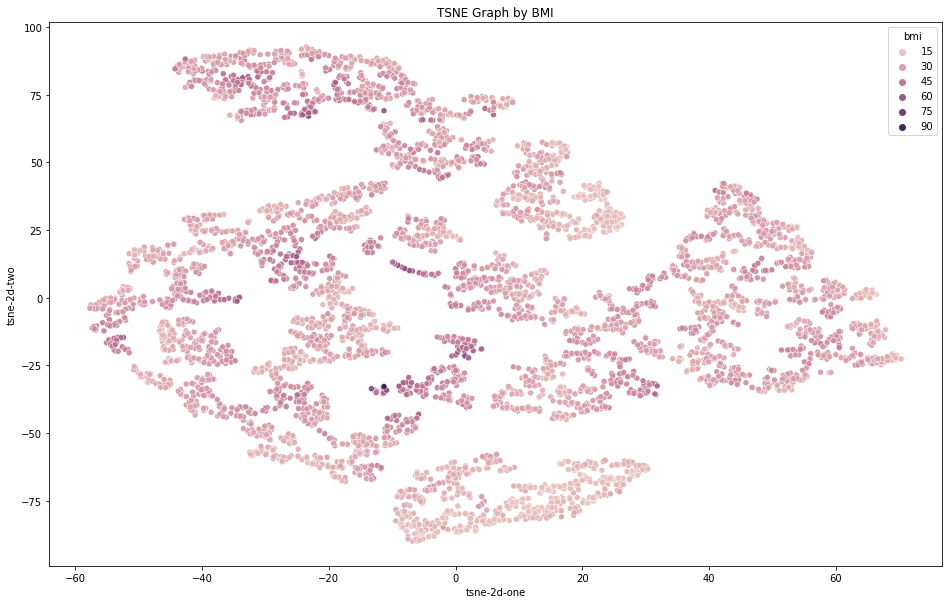

In [63]:

plt.figure(figsize=(16,10))
graph = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="bmi",
    data=combined_df,
    
  
)
graph.set_title("TSNE Graph by BMI")

Seems like BMI is all over the place